In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity
from numpy import log 

torch.manual_seed(123)

In [6]:

# Generalisable NN
torch.manual_seed(32)

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed):
        super().__init__()

        # Define size of input and output layers
        self.input_dim = input_dim
        self.output_dim = output_dim

        # Define size of hidden layers (number of neurons)
        self.layer_dim = layer_dim

        # Define how many hidden layers
        self.num_hidden = num_hidden

        # Define activation function of neurons 
        self.activation = nn.Tanh()

        # Define regularisation parameter
        self.reg_param = reg_param

        # Defin regularisation exponent power
        self.reg_power = reg_power

        # Define random seed to be used
        self.ran_seed = ran_seed

        # Build architectyre
        self.input_layer = nn.Linear(self.input_dim, self.layer_dim)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.layer_dim, self.layer_dim) for _ in range(num_hidden-1)])
        self.output_layer = nn.Linear(self.layer_dim, self.output_dim)
        self.layers = nn.ModuleList([self.input_layer, *self.hidden_layers, self.output_layer])

        # Initialise weights
        self.initialise()

    def forward(self, x):
    # Function defines the forward pass of the network
        for _, f in enumerate(self.layers[:-1]):
            x = self.activation(f(x))
        x = self.output_layer(x)
        return x
    
    def initialise(self):
    # Function defines initilaising the unfrozen weights of the network using Xavier (Glorot) initialisiation
        torch.manual_seed(self.ran_seed)
        def init_weights(m):
            if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
                g = nn.init.calculate_gain('tanh')
                #torch.nn.init.xavier_uniform_(m.weight, gain=g)
                torch.nn.init.xavier_normal_(m.weight, gain=g)
                m.bias.data.fill_(0)

        self.apply(init_weights)

    def regularization(self):
    # Function defines regularisation
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss = reg_loss + torch.norm(param, self.reg_power)
        return self.reg_param * reg_loss
    
    

Total Loss: 1.3536 | PDE Loss: -0.9318 | Boundary Loss: -0.2925 | Data Loss: -0.7554
Total Loss: 1.3516 | PDE Loss: -0.9311 | Boundary Loss: -0.2939 | Data Loss: -0.7557
Total Loss: 1.3427 | PDE Loss: -0.9281 | Boundary Loss: -0.2999 | Data Loss: -0.7574
Total Loss: 1.2430 | PDE Loss: -0.9033 | Boundary Loss: -0.3694 | Data Loss: -0.7752
Total Loss: 0.4012 | PDE Loss: -1.0219 | Boundary Loss: -1.4121 | Data Loss: -0.9430
Total Loss: 0.4006 | PDE Loss: -1.0218 | Boundary Loss: -1.4141 | Data Loss: -0.9434
Total Loss: 0.3979 | PDE Loss: -1.0217 | Boundary Loss: -1.4234 | Data Loss: -0.9452
Total Loss: 0.3699 | PDE Loss: -1.0204 | Boundary Loss: -1.5310 | Data Loss: -0.9655
Total Loss: 0.3697 | PDE Loss: -1.0205 | Boundary Loss: -1.5320 | Data Loss: -0.9657
Total Loss: 0.3686 | PDE Loss: -1.0207 | Boundary Loss: -1.5363 | Data Loss: -0.9664
Total Loss: 0.3573 | PDE Loss: -1.0236 | Boundary Loss: -1.5857 | Data Loss: -0.9742
Total Loss: 0.2758 | PDE Loss: -1.0558 | Boundary Loss: -2.3054 |

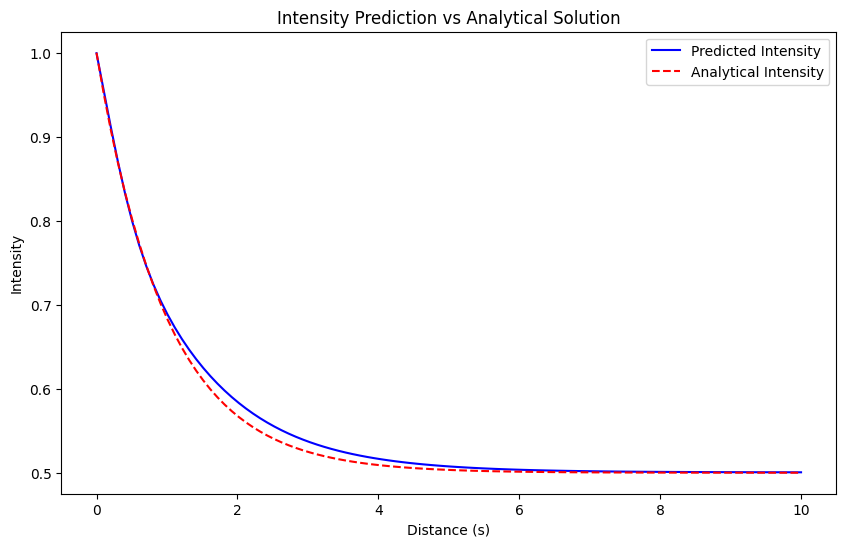

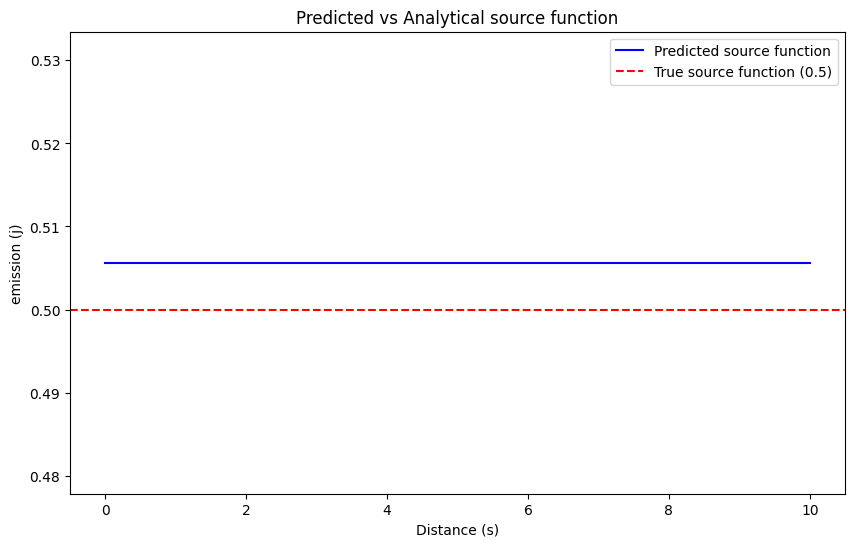

In [33]:
# Define the PINN class
class PINN(nn.Module):
    def __init__(self, balancing_parameter, input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed):
        super(PINN, self).__init__()

        # Initialize the NeuralNetwork for intensity and absorption coefficient
        self.intensity_network = NeuralNetwork(input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed)
        self.source_network = NeuralNetwork(input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed)
       
        self.balancing_parameter = balancing_parameter


    def compute_pde_residual(self, input_tau):
            '''
            Enforces PDE via automatic differentiation.
            Uses NN to predict intensity and absorption, and calculates dI/ds.
            '''
            input_tau.requires_grad = True

            # Predict intensity and absorption coefficient
            pred_intensity = self.intensity_network(input_tau)
            source_function = self.source_network(input_tau)

            # Compute derivative dI/dtau using autograd
            dintensity = torch.autograd.grad(pred_intensity.sum(), input_tau, create_graph=True)[0]

            # PDE residual: dI/dtau - source_function + intensity = 0
            residual = dintensity - source_function + pred_intensity
            return residual.reshape(-1,)
    
    def compute_loss(self, tau_bound, int_bound, input_tau, input_intensity, verbose=True):
        '''
        Computes loss using boundary conditions, physics residuals, and data loss.
        '''
        # Predict intensity at boundaries
        pred_boundary_intensity = self.intensity_network(tau_bound)

        int_bound = int_bound.view(-1, 1) # Reshape to match pred_boundary_intensity

        # Compute PDE residuals (physics enforcement)
        physics_residual = self.compute_pde_residual(input_tau)

    
        # Compute data residuals inside the slab
        pred_intensity = self.intensity_network(input_tau)
        data_residual = input_intensity - pred_intensity # Going to try and add measurment points 
        boundary_residual = pred_boundary_intensity - int_bound

        # Compute loss terms (L2 loss)
        physics_loss = torch.mean(abs(physics_residual)**2)
        data_loss = torch.mean(abs(data_residual)**2)
        boundary_loss = torch.mean((boundary_residual)**2)

        # Add regularization terms
        intensity_reg = self.intensity_network.regularization()
        source_reg = self.source_network.regularization()
    
        # Total loss (weighted combination)
        total_loss = torch.log(self.balancing_parameter * (boundary_loss) + physics_loss + intensity_reg + source_reg)
        
        if verbose:
            print(f"Total Loss: {total_loss.item():.4f} | PDE Loss: {torch.log10(physics_loss).item():.4f} | "
                f"Boundary Loss: {torch.log10(boundary_loss).item():.4f} | Data Loss: {torch.log10(data_loss).item():.4f}")
        
        return total_loss
    

# Define the function for the analytical solution
def analytical_solution(input_tau, source_value, I0=1.0):
    return source_value + (I0 - source_value)*torch.exp(-input_tau)
    

def plot_results(model, input_tau, input_intensity, analytical_solution, source_value):
    # Predict intensity from the trained model
    pred_intensity = model.intensity_network(input_tau).detach()

    # Compute the analytical solution using the true alpha value
    anal_intensity = analytical_solution(input_tau, source_value)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(input_tau.detach().numpy(), pred_intensity.detach().numpy(), label='Predicted Intensity', color='b')
    plt.plot(input_tau.detach().numpy(), anal_intensity.detach().numpy(), label='Analytical Intensity', color='r', linestyle='--')
    plt.xlabel('Distance (s)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.title('Intensity Prediction vs Analytical Solution')
    plt.show()

    pred_source = model.source_network(input_tau).detach().numpy().flatten()

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(input_tau.detach().numpy(), pred_source, label='Predicted source function', color='b')
    plt.axhline(y=source_value, color='r', linestyle='--', label=f'True source function ({source_value})')
    plt.xlabel('Distance (s)')
    plt.ylabel('emission (j)')
    plt.legend()
    plt.title('Predicted vs Analytical source function')
    plt.show()

def fit(model, optimizer, tau_bound, int_bound, input_tau, input_intensity, epochs):
    '''
    Fits the PINN model using Adam optimization.
    '''
    history = []  # Store loss values

    for epoch in range(epochs):
        def closure():
            optimizer.zero_grad()
            loss = model.compute_loss(tau_bound, int_bound, input_tau, input_intensity)
            loss.backward()
            history.append(loss.item())  # Store loss at each epoch
            return loss

        optimizer.step(closure)

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {history[-1]:.6f}")

    print(f"Final Loss: {history[-1]:.6f}")

def calculate_relative_l2_error(model, input_tau, analytical_solution, source_value):
    """
    Calculates the relative L2 error between the predicted intensity and the analytical solution as a percentage.
    """
    # Predict intensity from the trained model
    pred_intensity = model.intensity_network(input_tau).detach().flatten()

    # Compute the analytical solution using the true alpha value
    anal_intensity = analytical_solution(input_tau, source_value).flatten()

    # Compute the L2 norm of the difference between predicted and analytical solutions
    numerator = torch.norm(pred_intensity - anal_intensity, p=2)

    # Compute the L2 norm of the analytical solution
    denominator = torch.norm(anal_intensity, p=2)

    # Compute the relative L2 error as a percentage
    relative_l2_error = (numerator / denominator) * 100

    return relative_l2_error.item()

# ==== Initialize Model and Training ==== 
balancing_parameter = 5.0  # Adjust this if needed
input_dim = 1
output_dim = 1
layer_dim = 20
num_hidden = 6
reg_param = 0.001
reg_power = 1
ran_seed = 32

model = PINN(balancing_parameter, input_dim, output_dim, layer_dim, num_hidden, reg_param, reg_power, ran_seed)

#define Adam optimizer
optimizer_Adam = optim.Adam(
    list(model.intensity_network.parameters()) + list(model.source_network.parameters()),
    lr=1e-3,  # Adam optimizer typically uses learning rates like this
    betas=(0.5, 0.999),  # Lower momentum for better convergence
    eps=1e-8,  # Small value to prevent division by zero
    weight_decay=0  # LBFGS doesn't typically use weight decay, so keep it 0
)

# Define LBFGS optimizer
optimizer_LBFGS = optim.LBFGS(
    list(model.intensity_network.parameters()) + list(model.source_network.parameters()),
    lr=1e-3,
    max_iter=1000,
    max_eval=50000,
    history_size=150,
    line_search_fn="strong_wolfe",
    tolerance_change=np.finfo(float).eps
)

# ==== Training Data (Example Boundaries and Grid Points) ==== 
I0 = 1.0  # Initial intensity
source_value = torch.tensor(0.5)  # Source value

tau_bound = torch.tensor([[0.0], [10.0]])  # Slab distance from 0 to 10
int_bound = torch.tensor([I0, source_value + (I0 - source_value) * torch.exp(-tau_bound[1])])  # Intensity at boundaries
tau_min = tau_bound.min().item()
tau_max = tau_bound.max().item()
input_tau = torch.linspace(tau_min, tau_max, 100).view(-1, 1)  # Interior grid

input_intensity = analytical_solution(input_tau, source_value)

# Train the model
fit(model, optimizer_LBFGS, tau_bound, int_bound, input_tau, input_intensity, epochs=30)

# Calculate relative L2 error as a percentage
relative_l2_error = calculate_relative_l2_error(model, input_tau, analytical_solution, source_value)
print(f"Relative L2 Error: {relative_l2_error:.6f}%")

# Plot the results **only once** after training
plot_results(model, input_tau, input_intensity, analytical_solution,source_value)
